# WebScraping a letting agency site and populating a Database

In this project I shall scrape a local letting agent site. The URL is:
https://www.quicklets.com.mt/long-let-malta

Apartments and Penthouses for rent in Sliema, St. Julians and Gzira shall be scraped and inserted into a database hosted on my Google Drive. The information scraped consists of the property type, monthly rent, url and location.

In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive")
pathOut = "/content/drive/MyDrive/Colab Notebooks/Outputs"
os.chdir(pathOut)

import sqlite3

def CreateAppendDB(combined):
    db=sqlite3.connect("MaltaProperty.db")
    db.row_factory=sqlite3.Row
    db.execute("""create table if not exists 
    Property(linkurl TEXT PRIMARY KEY     NOT NULL,
         property_type   TEXT    NOT NULL,
         city            TEXT     NOT NULL,
         price        REAL);""")
    for x in range(0,len(combined)):
      try:
        db.execute("INSERT into Property(property_type,city,price,linkurl) values(?,?,?,?)",(combined["property_type"][x],combined["city"][x],combined["price"][x],combined["linkurl"][x]))
      except:
        print("Error with property: " + str(combined["linkurl"][x]))
    db.commit()

#@title
!pip install kora -q
from kora.selenium import wd
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
import cv2
from google.colab.patches import cv2_imshow

def Home():
    wd.get("https://www.quicklets.com.mt/")
    wd.maximize_window()
  
def ShowScreen():
  wd.save_screenshot("screenshot.png")
  screenshot = cv2.imread("screenshot.png")
  cv2_imshow(screenshot)

def Scroll_down(Num):
   page_body = wd.find_element_by_css_selector("body")
   x=1
   while (x<=Num):
       page_body.send_keys(Keys.ARROW_DOWN)
       x=x+1

def searchProp(inputType,inputLoc):
    inputs1 = wd.find_elements_by_class_name("select2-search__field")
    property_type = inputs1[0]
    location = inputs1[2]

    property_type.send_keys(inputType)
    time.sleep(1)
    selektor = wd.find_elements_by_class_name("select2-results__option")
    selektor[0].click()
    page_body = wd.find_element_by_css_selector("body")
    page_body.click()
    time.sleep(1)

    location.send_keys(inputLoc)
    time.sleep(1)
    selektor = wd.find_elements_by_class_name("select2-results__option")
    selektor[0].click()
    page_body = wd.find_element_by_css_selector("body")
    page_body.click()
    time.sleep(1)

    Scroll_down(3)

    searchBTN = wd.find_elements_by_class_name("btn-search")
    searchBTN[0].click()

def returndat():
    city = wd.find_elements_by_css_selector(".city")
    price = wd.find_elements_by_css_selector(".price")

    citytext = [x.text for x in city]
    linkurl = [x.get_attribute("href") for x in city]
    price = [x.text for x in price]
    price = [x.replace("€", "") for x in price]
    price = [x.replace("/mo", "") for x in price]
    price = [x.replace(",", "") for x in price]
    ls = []

    for x in price:
        try:
            ls.append(int(x))
        except:
            ls.append(0)

    mydata = pd.DataFrame({
        "city": citytext,
        "price": ls,
        "linkurl": linkurl
    })
    return (mydata)

def PageScrape():  
  Nrow = 0
  z=1
  while (Nrow <= resultNum):
    try:
      if z == 1:
        combined = returndat()
        Nrow = len(combined)
      else:
        newdata = returndat()
        combined = combined.append(newdata)
        Nrow = len(combined)
      Scroll_down(75)
      ShowScreen()
      PageBtn = wd.find_elements_by_css_selector(".pagination_ajax")
      NxtBtn = PageBtn[len(PageBtn)-1]
      NxtBtn.click()
      time.sleep(4)
    except:
      print("Error on iteration " + str(z))
      break
    z=z+1
  return(combined)

for x in ["apartment","penthouse"]:
  for y in ["sliema","gzira","julians"]:
    try:
      Home()
      searchProp(x,y)
      resultNum = int(wd.find_element_by_class_name("result").text.split(" ")[0])
      ShowScreen()
      print("A total of " + str(resultNum) + " properties have been found")
      combined = PageScrape()
      combined = combined.reset_index().drop(columns=["index"])
      combined = combined.drop_duplicates(subset=['linkurl'])
      combined["property_type"] = x
      combined["price"] = [float(x) for x in combined["price"]]
      CreateAppendDB(combined)
    except:
      print("No " + str(x) + " found in " + str(y))

Following execution of the above code, I now have an SQLite database with a Property table, hosted on my Google Drive.

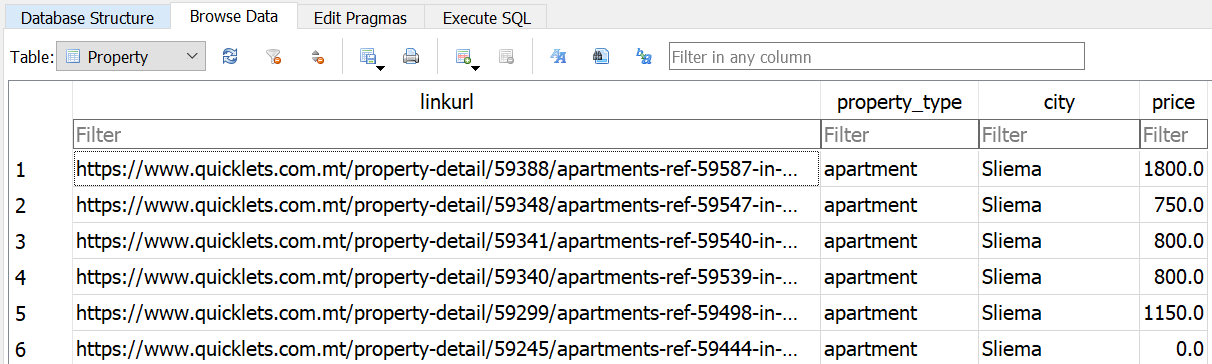

The following query gives me the average monthly rent per location:

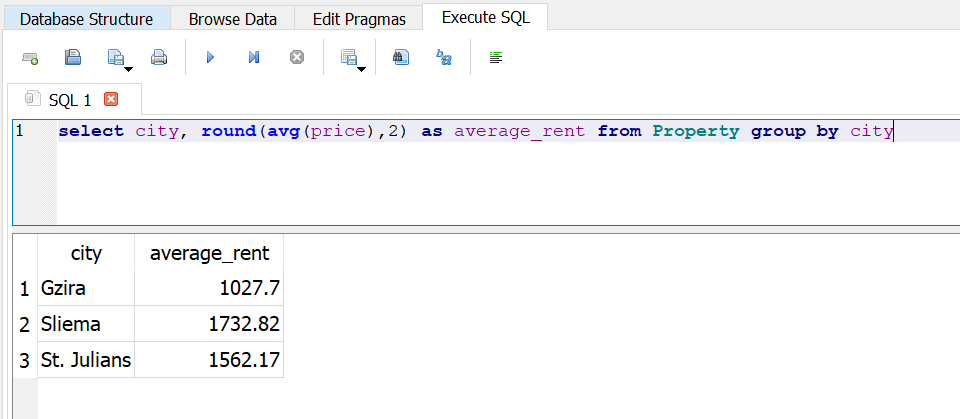